<a href="https://colab.research.google.com/github/rajunod/cookbooks_various/blob/main/NOAA_climo_percentiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workflow for Displaying Percentiles from CPC Data**

<img src = "https://www.nsstc.uah.edu/data/rjunod/UAH_AOSC_LOGO.png" alt="AOSC logo" width="500">

Example notebook to read in netCDF files of percentile data based on 1991-2020 reference period from NOAA.

>The material in this notebook is licensed for free and open consumption and resuse. All code is served under [GPUv3](https://www.gnu.org/licenses/gpl-3.0.html#license-text), while all non-code content is licensed under [Creative Commons BY 4.0 (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/). Please give appropriate credit to the notebook authors (**Rob Junod**) and the **Alabama Office of the State Climatologist**.

## Install dependencies

In [ ]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 78.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.4 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102744 sha256=efd24a49f9c473336625db46c9849c678fd143ba63be3c9bb1fed3266caa7428
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


## Import Necessary Packages

In [ ]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import fsspec

## Read in NOAA Percentile data from FTP site

For all three variables (`tmin`,`tmax`,`pcpn`), temporal smoothed or unsmoothed percentile data are available. The links are provided below:
- tmin-smoothed : https://ftp.cpc.ncep.noaa.gov/precip/climatologies/land_air/short_range/global/1991-2020/tmin/1deg/01d/tmin_clim_ptiles_01d.nc
- tmin-unsmooth : https://ftp.cpc.ncep.noaa.gov/precip/climatologies/land_air/short_range/global/1991-2020/tmin/1deg/01d/tmin_clim_ptiles_01d_unsmoothed.nc
- tmax-smoothed :
- tmax-unsmoothed :
- pcpn-smoothed :
- pcpn-unsmoothed :

---

This example will use the unsmoothed version of each variable but can be adapted easily by changing the link to the smoothed data version.

### `tmin` read and plot

> <b><p><font color="red"> Note: </font> </p>
> - Make sure your `date_str` variable is in the format '2001-MM-DD' with the year not changing. The month and day represents the percentile data for that day.
> - Change the `ptile_in` variable to your desired percentile from the list above. </b>

In [ ]:
# Month and day of interest
date_str = '2001-07-06'
# Only values within the netcdf are valid inputs, see above
ptile_in = 15
# url for either smoothed or unsmoothed data
url = "https://ftp.cpc.ncep.noaa.gov/precip/climatologies/land_air/short_range/global/1991-2020/tmin/1deg/01d/tmin_clim_ptiles_01d_unsmoothed.nc"

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


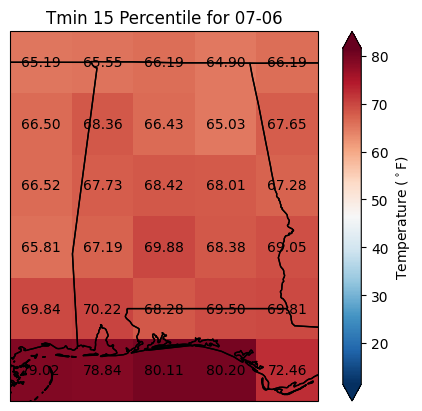

In [ ]:
# tmin read in
with fsspec.open(url) as f:
   tmin = xr.open_dataset(f)

   # Get min and max values for static plot
   max_val = tmin.sel(ptile=ptile_in,latitude=slice(35,30),longitude=slice(271,275)).tmin.min()
   min_val = tmin.sel(ptile=ptile_in,latitude=slice(35,30),longitude=slice(271,275)).tmin.max()

   # Get latitude and longitude values for plotting text values
   lats = tmin.sel(latitude=slice(35,30),longitude=slice(271,275)).latitude.values
   lons = tmin.sel(latitude=slice(35,30),longitude=slice(271,275)).longitude.values

   # Subset dataset in degrees F
   tmin_sub = (tmin.sel(ptile=ptile_in,date = date_str,latitude=slice(35,30),longitude=slice(271,275)).copy()*9/5)+32

   fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
   tmin_sub.tmin.plot(ax=ax,vmin=(min_val*9/5)+32,vmax=(max_val*9/5)+32,cmap='RdBu_r', cbar_kwargs={"label": "Temperature ($^\circ$F)"})
   for i in lons:
    for j in lats:
        ax.text(i,j,f'{tmin_sub.sel(latitude=j,longitude=i).tmin.values:.2f}',ha='center',va='center',transform=ccrs.PlateCarree())
   ax.coastlines()
   ax.add_feature(cf.STATES)
   ax.set_title(f"Tmin {ptile_in} Percentile for {date_str.split('-')[1]}-{date_str.split('-')[2]}")

In [ ]:
# If you need to look at the data
tmin

<xarray.Dataset>
Dimensions:    (date: 365, ptile: 19, latitude: 181, longitude: 360)
Coordinates:
  * latitude   (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * ptile      (ptile) int64 1 2 5 10 15 20 25 33 40 ... 67 75 80 85 90 95 98 99
  * date       (date) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
Data variables:
    tmin       (date, ptile, latitude, longitude) float64 ...
Attributes:
    window:            01d
    years:             [1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 200...
    smoothing_window:  31
    contact:           mike.charles@noaa.gov
    comment:           Climatological percentiles are smoothed temporally, ov...